# Práctica 5: Detección basada en ligandos: aprendizaje automático

## Teoría

<img src="./img/ML_overview.png" width="200" align='right'>

Para aplicar ML con éxito, necesitamos un gran conjunto de datos de moléculas, una codificación molecular (huellas dactilares), una etiqueta por molécula en el conjunto de datos (inactivo: 0, activo: 1) y un algoritmo de ML para entrenar un modelo. Entonces, podemos hacer predicciones para nuevas moléculas.

### Aprendizaje automático (AA)

Se puede solicitar ML (ver también [página de scikit-learn](http://scikit-learn.org/stable/)):

En esta práctica se trabaja en una **Clasificación (supervisada)**: identificar a qué categoría pertenece un objeto, utilizando un modelo de clasificación **Random Forest** (Múltiples árboles de decisión que producen una predicción media).
<img src="./img/RF_example.png" width="200" align='right'>

### Estrategia de validación: validación cruzada de K-fold

* Esta técnica de validación del modelo divide el conjunto de datos en dos grupos de manera iterativa:
    * Conjunto de datos de entrenamiento: Considerado como el conjunto de datos conocido sobre el que se entrena el modelo
    * Conjunto de datos de prueba: conjunto de datos desconocido en el que luego se prueba el modelo
    * El proceso se repite k veces

* El objetivo es probar la capacidad del modelo para predecir datos que nunca antes se habían visto para detectar problemas conocidos como sobreajuste y evaluar la capacidad de generalización del modelo.

### Medidas de desempeño
<img src="./img/FP_TP_fig.png" width="250" align='right'>

* **Sensibilidad**, también tasa de verdaderos positivos: TPR = TP/(FN+TP)
* **Especificidad**, también tasa negativa verdadera: TNR = TN/(FP + TN)
* **Precisión**, también la veracidad: ACC = (TP + TN)/(TP + TN + FP + FN)
* **Curva ROC**, curva característica de funcionamiento del receptor
    * Un diagrama gráfico que ilustra la capacidad de diagnóstico de nuestro clasificador
    * Traza la sensibilidad frente a la especificidad.
* **AUC**, el área bajo la curva de la roca (AUC):
    * Describe la probabilidad de que un clasificador clasifique una instancia positiva elegida al azar más alta que una negativa
    * Valores entre 0 y 1, cuanto más alto mejor

# Preparación de los datos
Iniciando importando los datos de la práctica anterior, como está guardada en una carpeta diferente, lo primero que tenemos que hacer es crear un `directorio raíz` (`ROOT_DIR`) para poder navegar hasta el archivo
## Carga de los datos

In [1]:
# Librerias necesarias para importar la base de datos guardada
import pandas as pd
import os
from pathlib import Path

current_directory = os.getcwd()
ROOT_DIR = Path(current_directory).parent
uniprot_id = 'P49841'
print('Directorio raíz:', ROOT_DIR)
df_output = pd.read_csv(f'{ROOT_DIR}/2_PART_TWO/data/compounds_P49841_lipinski.csv')
df_output.head()

Directorio raíz: C:\Users\caramirezs\My Drive\Python\DS-for-DD


,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes


En esta práctica necesitamos solamente los ligandos que cumplen la *regla de los cinco*, por tanto, debemos filtrar por la columna: `rule_of_five_conform:yes`. Además, solamente necesitamos las primeras tres columnas

In [2]:
print(f'# lignados totales: {len(df_output)}')
df_output = df_output[df_output['rule_of_five_conform']=='yes']
df_output = df_output[['molecule_chembl_id', 'pchembl_value', 'smiles']]
print(f'# ligandos filtrados (rule_of_five_conform:yes): {len(df_output)}')

df_output.head()

# lignados totales: 2657
# ligandos filtrados (rule_of_five_conform:yes): 2477


,molecule_chembl_id,pchembl_value,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...


## Procesamiento de los datos
### Fingerprints
Para entrenar el algoritmo, debemos convertir los ligandos en una lista de características. En este momento tenemos la estructura molecular (smile) de cada ligando, con esta información podemos importar el *fingerprint* y usar esta nueva representación para entrenar el modelo.

Para encontrar e importar las fingerprints de cada ligando se utiliza la librería `rdkit`, creando una nueva columna en el dataset con el fingerprint. Hay varios tipos de fingerprint, por ahora bamos a trabajar con [Extended Connectivity Fingerprint ECFP](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md) también conocida como morgan2_c/ecfp4

In [3]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
df_fp = df_output.copy()
df_fp['morgan2_c'] = df_output.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())
df_fp = df_fp[['morgan2_c', 'pchembl_value']]
df_fp.head()

,morgan2_c,pchembl_value
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70


Exploremos el primer fingerprint: es una lista binaria (unos y ceros) con una longitud de 2048 elementos. Estos elementos de la fingerprint serán las características que se usarán para entrenar el modelo.

In [4]:
print(df_fp.morgan2_c[0])
print(len(df_fp.morgan2_c[0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Clasificación de los ligandos
Cada ligando debe ser clasificado como **activo** o **inactivo**, para esto usaremos la columna `pIC50` definiendo umbrales de actividiad
La proteína *Glycogen synthase kinase-3 beta* se clasifica en el grupo de las * Kinasas*, por tanto, usaremos los siguientes umbrales:
**Inactivo**: *pchem_value* < 6.52 uM
**Activo**: **pchem_value* >= 7.52 uM

In [5]:
# Eliminar columnas innecesarias
# Agregar columna para actividad, predeterminado = internet
df_fp['activity_type'] =  'Intermediate'
# Marcar cada molécula como activa con un pIC50 >= 7.52
df_fp.loc[df_fp[df_fp.pchembl_value >= 7.5].index, 'activity_type'] = 'Active'
# Marcar cada molécula como inactiva con un pIC50 de < 6.52
df_fp.loc[df_fp[df_fp.pchembl_value < 6.52].index, 'activity_type'] = 'Inactive'
df_fp.head()

,morgan2_c,pchembl_value,activity_type
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


Veamos gráficamente cómo quedo la clasificación

activity_type
Inactive        1178
Intermediate     676
Active           623
Name: count, dtype: int64


<Axes: xlabel='activity_type'>

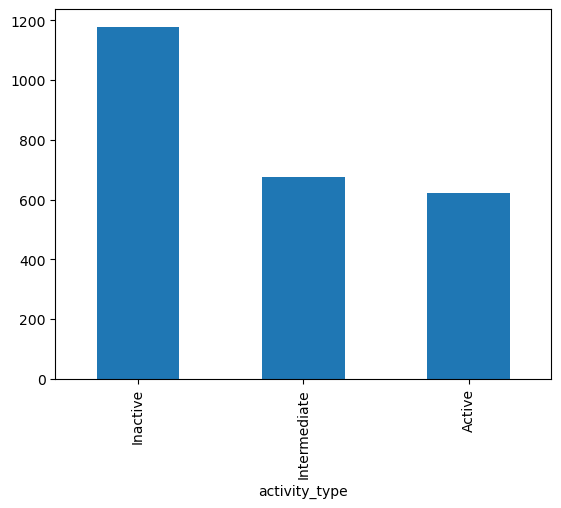

In [6]:
print(df_fp.activity_type.value_counts())
df_fp.activity_type.value_counts().plot.bar(x='activity_type')

Ahora filtramos los datos quitando aquellos que quedaron como *Intermedios*

# ligandos (active/inactive): 1801
activity_type
Inactive    1178
Active       623
Name: count, dtype: int64


,morgan2_c,pchembl_value,activity_type
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


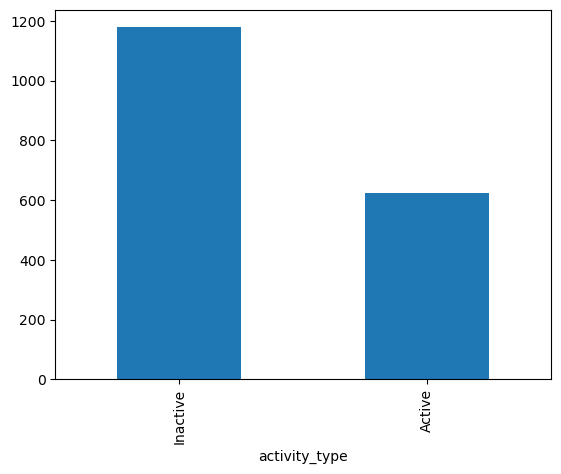

In [7]:
bd = df_fp[df_fp['activity_type'] != 'Intermediate'].copy()
bd.activity_type.value_counts().plot.bar(x='activity_type')
print(f'# ligandos (active/inactive): {len(bd)}')
print(bd.activity_type.value_counts())
bd.head()

Como es una clasificación binaria, debemos asignar una etiqueta: (Inactive:0 / Active:1)

In [8]:
bd['activity'] = 0
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0
bd.drop(['activity_type', 'pchembl_value'], axis=1, inplace=True)
bd.head()

,morgan2_c,activity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


Ya tenemos las características(morgan2_c) y etiquetas (activity) para poder entrenar el modelo


# Machine Learnig

## Entrenamiento del modelo

Vamos a entrenar un modelo que clasifique ligandos conociendo el fingerprint. El objetivo es probar la capacidad del modelo para predecir datos que nunca antes había visto para detectar problemas conocidos como sobreajuste y evaluar la capacidad de generalización del modelo.

### Random Forest
Usualmente, el primer paso es **dividir** el conjunto de datos, una parte para el entrenamiento (70%) y la otra parte para la validación(30%).


In [9]:
from sklearn.model_selection import train_test_split
fp_df_train, fp_df_valid = train_test_split(bd, test_size=0.3, random_state=142857,
                                            shuffle=True, stratify=bd['activity'])
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_valid.reset_index(drop=True, inplace=True)
print(f'# datos entrenamiento: {len(fp_df_train)},'
      f'\n# datos validación: {len(fp_df_valid)}')

# datos entrenamiento: 1260,
# datos validación: 541


Ahora, para cada conjunto vamos a separar las características (el fingerprint) y la etiqueta

In [10]:
X_train, y_train = fp_df_train.morgan2_c, fp_df_train.activity
X_valid, y_valid = fp_df_valid.morgan2_c, fp_df_valid.activity
# El vector de características se deben convertir a una lista de elementos
X_train, X_valid = X_train.tolist(), X_valid.tolist()

Escogemos el estimador de [Random Fores classificator](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para entrenar el modelo, se debe instanciar y construir el modelo

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Validación
### Puntuación de precisión
Exsiten varias métricas para medir la capacidad del modelo para hacer predicciones, vamos a ver un ejemplo usando la métrica [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score). Para lo cual se debe primero clasificar (*predecir*) los datos del y luego compararlos con las etiquetas verdaderas, esto lo haremos tanto con el **conjunto de entrenamiento** como con el **conjutno de validación**:

In [12]:
from sklearn.metrics import accuracy_score
# Predicción conjunto de entrenamiento
y_train_pred = model.predict(X_train)
# Predicción conjunto de validación
y_valid_pre = model.predict(X_valid)

# Puntuación
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pre)
print(f'Accuracy conjunto de entrenamiento: {acc_train:.4f} ({acc_train:.2%})\n'
      f'Accuracy conjunto de validación: {acc_valid:.4f} ({acc_valid:.2%})')


Accuracy conjunto de entrenamiento: 1.0000 (100.00%)
Accuracy conjunto de validación: 0.8835 (88.35%)


El *accuracy** del conjunto de entrenamiento es del 100% indica un caso de *Overfitting*, posiblemente se deba hacer un ajuste de los parámetros del modelo de clasificación o incluso utilizar otro modelo.

### Matriz de confusión
Con esta matriz se puede comparar las etiquetas verdaderas versus las predicciones, [aquí](https://en.wikipedia.org/wiki/Confusion_matrix) se puede ver más infiormación.

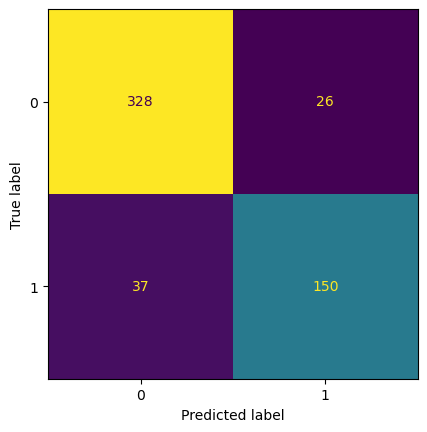

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_valid, y_valid_pre, colorbar=False)

### Curva ROC
La curva ROC (ROC curve, Receiver Operating Characteristic) es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación, usualmente se suele utilizar para representar qué tan bueno es el modelo, veamos como se puede construir una:

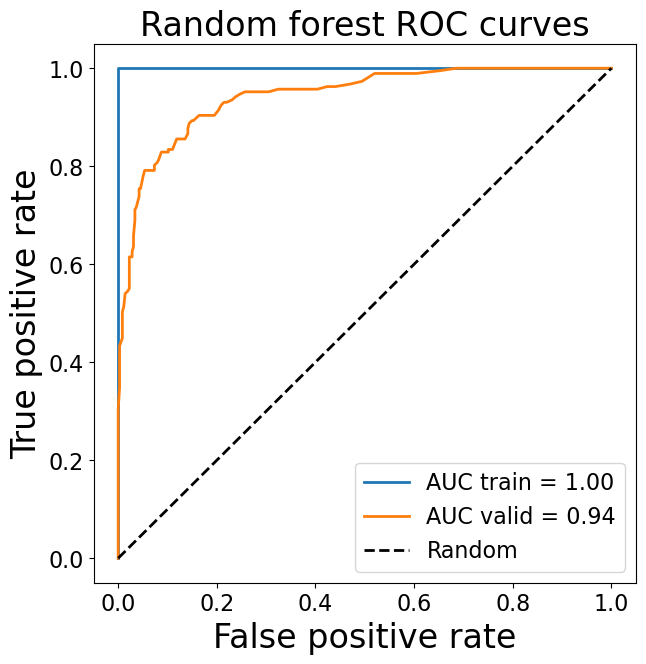

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib as mpl
import matplotlib.pyplot as plt

# Probabilidad de las predcciones
pred_prob_train = model.predict_proba(X_train)[:, 1]
pred_prob_valid = model.predict_proba(X_valid)[:, 1]

# tasas de falsos positivos / tasas de verdaderos positivos - entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# tasas de falsos positivos / tasas de verdaderos positivos - validación
fpr_valid, tpr_valid, _ = roc_curve(y_valid, pred_prob_valid)
roc_auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_valid, tpr_valid, label=f'AUC valid = {roc_auc_valid:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Curva aleatoria

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

### K-fold (validación cruzada)

Vamos dividir los datos en 5 conjuntos, cada uno de ellos entrenará el algoritmo y medirá su capacidad de predicción, luego se contrastarán los datos de los cinco modelos para validar si el modelo entrenado funciona o no.

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

n_folds = 5
# Vector de resultados vacío
results = []
# Mezcla los índices para la validación cruzada de k-fold
kf = KFold(n_splits=n_folds, shuffle=True)
# Etiquetas inicializadas con -1 para cada punto de datos
labels = -1 * np.ones(len(bd))
# Modelo de instancia
model = RandomForestClassifier()

for train_index, test_index in kf.split(bd):
    # Entrenamiento
    # Convierte el vector de bits y la etiqueta en una lista
    train_x = bd.iloc[train_index].morgan2_c.tolist()
    train_y = bd.iloc[train_index].activity.tolist()

    # Ajustar el modelo
    model.fit(train_x, train_y)

    # Pruebas
    # Convierte el vector de bits y la etiqueta en una listat
    test_x = bd.iloc[test_index].morgan2_c.tolist()
    test_y = bd.iloc[test_index].activity.tolist()
    # Predecir en el conjunto de prueba
    prediction_prob = model.predict_proba(test_x)[:, 1]
    # Guardar la etiqueta predicha de cada pliegue
    labels[test_index] = model.predict(test_x)

    # Actuación
    # Obtenga fpr, tpr y roc_auc para cada pliegue
    fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
    roc_auc_l = auc(fpr_l, tpr_l)
    # Agregar a los resultados
    results.append((fpr_l, tpr_l, roc_auc_l))
# Obtenga precisión general, sensibilidad, especificidad
y = bd.activity.tolist()
acc = accuracy_score(bd.activity.tolist(), labels)
sens = recall_score(bd.activity.tolist(), labels)
spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))

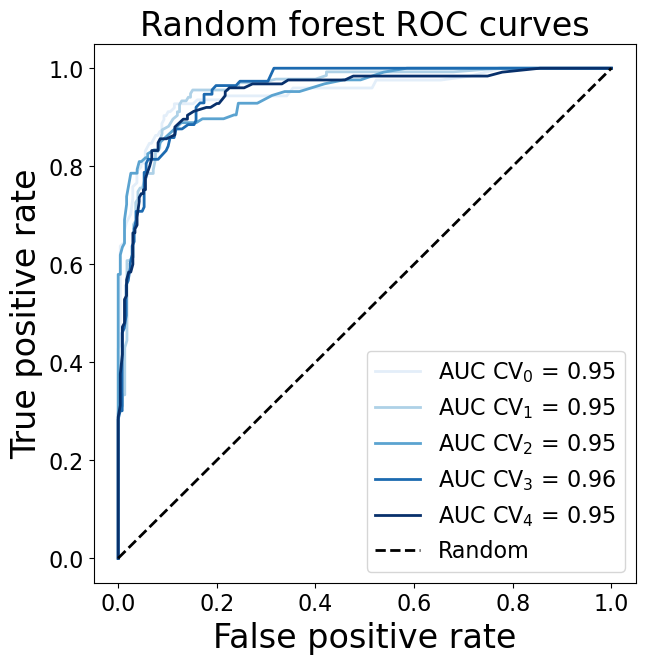

In [16]:
plt.figure(figsize=(7, 7))
cmap = mpl.colormaps['Blues']
colors = [cmap(i) for i in np.linspace(0.1, 1.0, n_folds)]

for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(results):
    plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title(f'Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

plt.show()

In [18]:

# Calcule el AUC media e imprima
m_auc = np.mean([elem[2] for elem in results])
print(f'Mean AUC: {m_auc:.3f}')

# Mostrar precisión general, sensibilidad, especificidad
print(f'Sensitivity: {sens:.3f}\nAccuracy: {acc:.3f}\nSpecificity: {spec:.3f}')

Mean AUC: 0.952
Sensitivity: 0.803
Accuracy: 0.896
Specificity: 0.945
